In [1]:
import argparse
import torch
import os
from matplotlib import pyplot as plt
import numpy as np
import random
import joblib
import pandas as pd

from utils import rolling_window, acf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--nz', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=80)
    parser.add_argument('--seq_len', type=int, default=127)
    parser.add_argument('--device', type=str, default=None)
    parser.add_argument('--log_dir', type=str, default='./logs')

    args = parser.parse_args([])
    return args

args = parse_args()

In [33]:
nz = args.nz
batch_size = args.batch_size


if args.device:
    device = torch.device(args.device)
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_processor = joblib.load(os.path.join(args.log_dir, 'data_processor.joblib'))
generator = torch.load(os.path.join(args.log_dir, 'generator.pth')).to(device)
generator.eval()

seq_len = len(data_processor.log_returns)

noise = torch.randn(batch_size, nz, seq_len).to(device)
with torch.no_grad():
    gen_y = generator(noise).cpu().detach().squeeze()

y = data_processor.postprocess(gen_y)

In [34]:
len(data_processor.log_returns)

2433

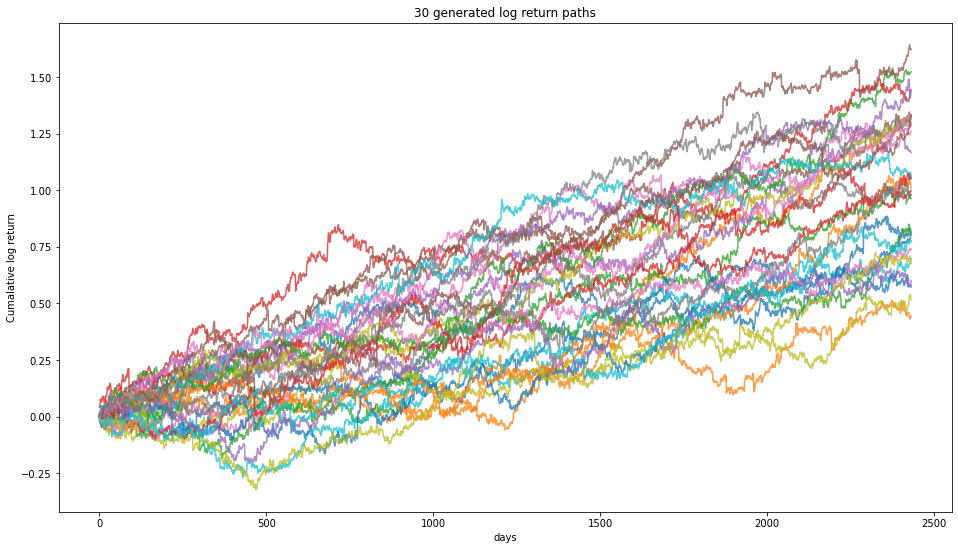

In [36]:
# Chart 1
_, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
plt.savefig(os.path.join(args.log_dir, 'cumalative_log_return.png'))

In [38]:
df = pd.read_csv('sample/sp500.csv')
df['Date'] = df['Date'].apply(pd.Timestamp)
df = df[(df['Date'] >= '2009-05-01') & (df['Date'] <= '2018-12-31')]

In [39]:
data = df['Adj Close']

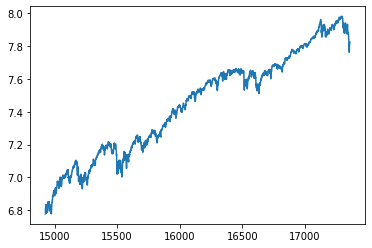

In [40]:
plt.plot(np.log(data))

877.52002

In [94]:
y = data_processor.log_returns
y = np.cumsum(y)

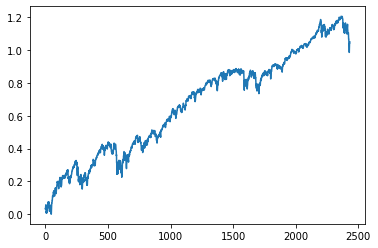

In [95]:
plt.plot(np.cumsum(data_processor.log_returns))

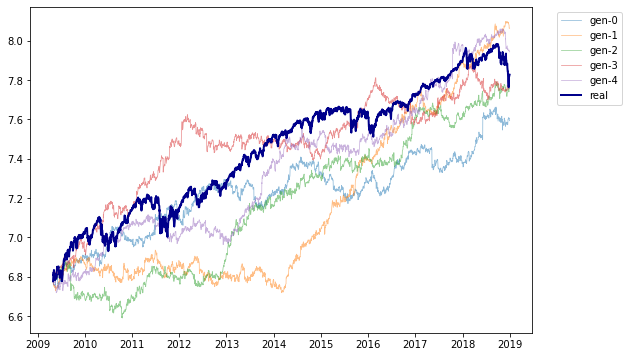

In [92]:
log_path = 

fig, ax = plt.subplots(figsize=(9, 6))
for idx in range(5):
    init_value = 0 # np.log(data.iloc[0])
    x = [init_value]
    for i in y[idx,:]:
        x.append(i + x[-1])    
    ax.plot(df.Date, x, label=f'gen-{idx}', alpha=0.5, linewidth=0.75)
ax.plot(df.Date, np.log(data.tolist()), label='real', linewidth=2, color='darkblue')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.close()